<a href="https://colab.research.google.com/github/julianpietsch/biophysics2025/blob/main/gillespie_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gillespie simulation

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy import stats
from matplotlib import pyplot as plt
rng = np.random.default_rng()

## Bursty protein production

Here we model two species, mRNA and protein, using Gillespie's stochastic simulation algorithm. For each species, we have production and degradation reactions:

\begin{align}
\emptyset &\to \mathrm{mRNA} & (0)\\
\mathrm{mRNA} &\to \emptyset & (1)\\
\mathrm{mRNA} &\to \mathrm{mRNA} + \mathrm{protein} & (2)\\
\mathrm{protein} &\to \emptyset & (3)
\end{align}

In [2]:
# 'Bursty' protein production
V = 1  # reaction volume
c = np.r_[2, 2, 20, 1]  # reaction probabilities
s = np.array([  # reaction stoichiometries:
    [ 1, 0],
    [-1, 0],
    [0,  1],
    [0, -1]
])
x0 = np.r_[0, 0]  # [mRNA, protein]

def step(x, c, s):
  # Calculate hazards
  a = np.r_[
    c[0], # mRNA transcription
    c[1] * x[0], # mRNA decay
    c[2] * x[0], # protein translation
    c[3] * x[1] # protein decay
  ]

  # Randomly sample the amount of time elapsed without any reactions occurring
  dt = (1 / a.sum()) * np.log(1 / rng.uniform())

  # Randomly sample the next reaction to simulate
  rxn = np.argmin(np.cumsum(a) <= a.sum() * rng.uniform())

  return dt, x + s[rxn]

# Run simulation
N_steps = 10000
t = np.full(N_steps, np.nan)
x = np.full((N_steps, 2), np.nan)
x[0] = x0
t[0] = 0
for i in range(1, t.size):
  dt, x[i] = step(x[i-1], c, s)
  t[i] = t[i-1] + dt

We also solve the equivalent deterministic rate equation:

In [3]:
k = c * np.r_[1 / V, 1, 1, 1]
def ode(t, x):
   return np.r_[
       k[0] - k[1] * x[0],
       k[2] * x[0] - k[3] * x[1]
   ]

t_det = np.linspace(0, t.max(), 200)
det_soln = solve_ivp(ode, [t_det.min(), t_det.max()], x0, t_eval=t_det)

Finally plot the stochastic and deterministic solutions together:

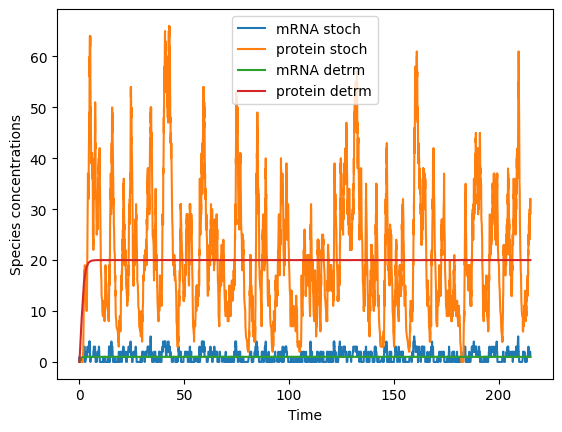

In [4]:
plt.plot(t, x / V, label=['mRNA stoch', 'protein stoch'])
plt.plot(t_det, det_soln.y.T, label=['mRNA detrm', 'protein detrm'])
plt.xlabel('Time')
plt.ylabel('Species concentrations')
plt.legend()
plt.show()

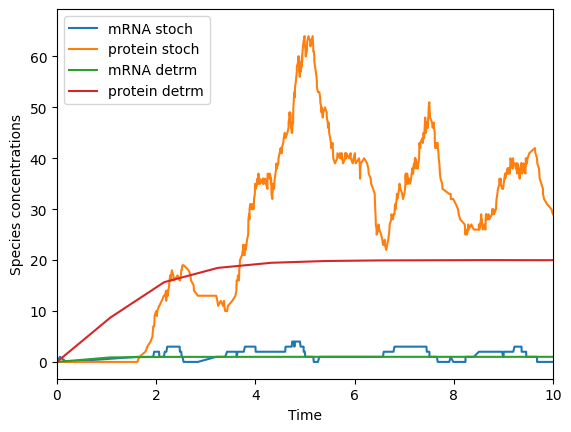

In [5]:
plt.plot(t, x / V, label=['mRNA stoch', 'protein stoch'])
plt.plot(t_det, det_soln.y.T, label=['mRNA detrm', 'protein detrm'])
plt.xlabel('Time')
plt.ylabel('Species concentrations')
plt.legend()
plt.xlim([0, 10])
plt.show()

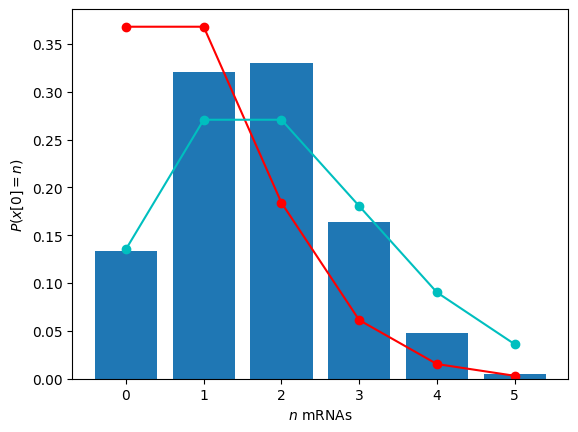

In [11]:
mRNA_vals, mRNA_counts = np.unique(x[:, 0], return_counts=True)
plt.bar(mRNA_vals, mRNA_counts / mRNA_counts.sum())
plt.plot(stats.poisson.pmf(mRNA_vals, 1), 'ro-')
plt.plot(stats.poisson.pmf(mRNA_vals, 2), 'co-')
plt.xlabel('$n$ mRNAs')
plt.ylabel('$P(x[0] = n)$')
plt.show()

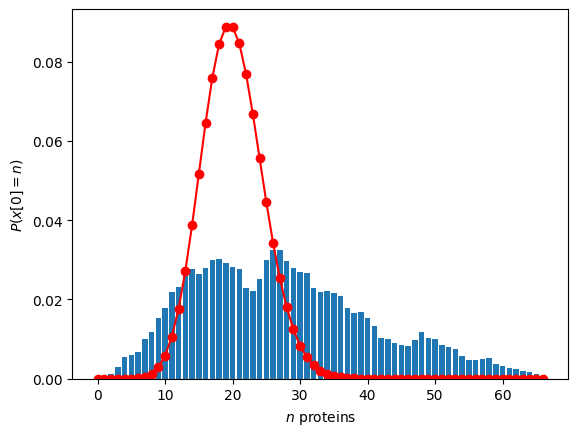

In [7]:
protein_vals, protein_counts = np.unique(x[:, 1], return_counts=True)
plt.bar(protein_vals, protein_counts / protein_counts.sum())
plt.plot(stats.poisson.pmf(protein_vals, 20), 'ro-')
plt.xlabel('$n$ proteins')
plt.ylabel('$P(x[0] = n)$')
plt.show()